# Melissa (Dumb Model #1)



## Notebook Context
Melissa is the name of one of the "dumb models" Set up with which to compare the performance of Littlefoot to. In this notebook - Melissa is incarnated as either a HOG (histogram of gradients) + LSVG implementation, or an IoU (intersection over union) angle estimator. (the latter is an original brainwave by yours truly)

YEET


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 1: Dataset Retrieval and Management
The Dataset used for this experiment is found in the mounted Google Drive folder (if not mounted, contact me and we can try sort it out). The dataset consists of images, and json labels for those images. The json labels contain the driving angle as floating point values in the range of -1 and 1. -1 means all the way left, and 1 means all the way to the right. We are not addressing throttle labels in this experiment. 


In [18]:
#Mount Data Folder From Google Drive:
path0 = "./GenTrack5Throttle/"
path1 = "./DefRoad5Throttle/"
path2 = "./WH5Throttle/"


In [ ]:
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/GenTrack5Throttle.zip'
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/WH5Throttle.zip'
!unzip '/content/drive/My Drive/DIYRobocars_2020/Data/DonkeyGymData_Jul2020/DefRoad5Throttle.zip'

In [19]:
#Import required packages for this step:
%tensorflow_version 2.x
import os   #For retrieving files
import natsort #For sorting retrieved files
import numpy as np #Calculations, arrays, etc.
import cv2 #Image preprocessing, loading and saving images
import json #For processing json files
import tensorflow as tf  #For the ML side
from random import randrange 

import matplotlib.pyplot as plt #Plots


#Make sure plots happen inline


%matplotlib inline

In [20]:
#Donkey Training and Val data splits
def train_test_split(data_list,label_list, test_size,shuffle=True):
    '''
    take a list, split it into two sets while selecting a 
    random element in order to shuffle the results.
    use the test_size to choose the split percent.
    shuffle is always True, left there to be backwards compatible
    '''
    assert shuffle
    data_list = list(data_list)
    label_list = list(label_list)
    train_data = []
    traina_labels =[]

    target_train_size = len(data_list) * (1. - test_size)

    i_sample = 0

    while i_sample < target_train_size and len(data_list) > 1:
        i_choice = np.random.randint(0, len(data_list) - 1)
        train_data.append(data_list.pop(i_choice))
        traina_labels.append(label_list.pop(i_choice))
        i_sample += 1

    # remainder of the original list is the validation set
    val_data = data_list
    vala_labels = label_list
    del data_list
    del label_list
    return val_data, vala_labels

In [69]:
#Fetch data for evaluations

images = []
labels = []
#Collect images into respective lists:

for file in os.listdir(path0):
    if 'cam' in file:
        images.append(path0+file)
    elif 'record' in file:
        labels.append(path0+file)

images = natsort.natsorted(images)
labels = natsort.natsorted(labels)

images, labels = train_test_split(images, labels, 0.7)
#images = images[9000:]
#labels = labels[9000:]

print("Labels and images order check:")
print(images[10])
print(labels[10])
print(len(images))
print(len(labels))

Labels and images order check:
./GenTrack5Throttle/13_cam-image_array_.jpg
./GenTrack5Throttle/record_13.json
11196
11196


In [70]:
#Threshold
def AdaptCanny(image, Block=23, Const=-15):

  #Canny Edge Detection
  image = image*255
  image = np.asarray(image, dtype=np.uint8)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  imaget= cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,Block,Const)
  imaget = imaget/255
  width = 120
  height = 160
  factor = 2.25
  factor2 = 1.3
  imaget[0:int(round(width/factor)),:] = 0
  imaget[int(round(width/factor2)):,:] = 0
  imaget = imaget.astype(np.uint8)
  return imaget
  


File Check:


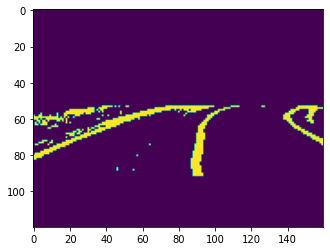

0.21069035
0.05
0.21069034792514973
0.05
./GenTrack5Throttle/13_cam-image_array_.jpg
./GenTrack5Throttle/record_13.json


In [71]:
#Directly reading data into val data split to save RAM
try:
  del ximages
  del ximagest
  del ylabelsa
except:
  print('Nothing to Delete')
import cv2 as cv


width = 120 #set image width
height = 160 #set image height
color = 3  #set colour channels
dim = (width, height) #Create dimension tuple


#Read Images and Labels into arrays:

ximages = np.zeros((len(images), 120, 160, 3), dtype=np.float32)
ximagest = np.zeros((len(images), 120, 160), dtype=np.float32)


ylabelsa = np.zeros(len(labels), dtype=np.float32)
ylabelst = np.zeros(len(labels), dtype=np.float32)

for i in range(len(images)):
    ximages[i,:,:,:] = cv.imread(images[i])
    ximages[i] = ximages[i]/255 #Normalise between 0 and 1 - better for tf
    ximagest[i] = AdaptCanny(ximages[i])
    with open(labels[i]) as file:
        jdata = json.load(file)
        ylabelsa[i] = jdata['user/angle']   #angle data
    with open(labels[i]) as file:
        jdata = json.load(file)    
        ylabelst[i] = jdata['user/throttle'] #throttle data

print("File Check:")
image = cv.imread(images[300])
plt.imshow(image)
plt.show()
plt.imshow(ximagest[300])
plt.show()
print(ylabelsa[300])
print(ylabelst[300])
with open(labels[300]) as file:
    tdata = json.load(file)
    print(tdata['user/angle'])
with open(labels[300]) as file:
    tdata = json.load(file)
    print(tdata['user/throttle'])
    
print(images[10])
print(labels[10])

## Melissa \#1: IoU

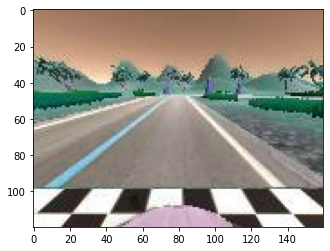

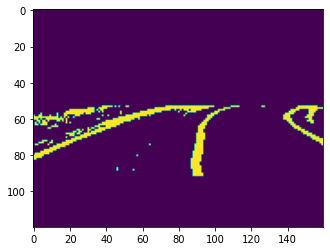

0.0
0.3166666626930237
0.21069035


In [72]:


#Basicc IOU
import keras.backend as K

def iou(y_true, y_pred, label: int):
    """
    Return the Intersection over Union (IoU) for a given label.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
        label: the label to return the IoU for
    Returns:
        the IoU for the given label
    """
    # extract the label values using the argmax operator then
    # calculate equality of the predictions and truths to the label
    y_true = K.cast(K.equal(K.argmax(y_true), label), K.floatx())
    y_pred = K.cast(K.equal(K.argmax(y_pred), label), K.floatx())
    # calculate the |intersection| (AND) of the labels
    intersection = K.sum(y_true * y_pred)
    # calculate the |union| (OR) of the labels
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    # avoid divide by zero - if the union is zero, return 1
    # otherwise, return the intersection over union
    return K.switch(K.equal(union, 0), 1.0, intersection / union)

#Test on Same image:

image1 = AdaptCanny(ximages[10])
image2 = AdaptCanny(ximages[300])

plt.imshow(ximages[10])
plt.show()
plt.imshow(image1.astype(np.uint8))
plt.show()
plt.imshow(image2.astype(np.uint8))
plt.show()

label = K.argmax(image1)
iousame = iou(image1, image1, label)
ioudiff = iou(image1, image2, label)
print(1 - K.get_value(iousame))
print(1 - K.get_value(ioudiff))
print(ylabelsa[300])

In [73]:

from keras import backend as K


def iou(y_true, y_pred, label: int):
    """
    Return the Intersection over Union (IoU) for a given label.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
        label: the label to return the IoU for
    Returns:
        the IoU for the given label
    """
    # extract the label values using the argmax operator then
    # calculate equality of the predictions and truths to the label
    y_true = K.cast(K.equal(K.argmax(y_true), label), K.floatx())
    y_pred = K.cast(K.equal(K.argmax(y_pred), label), K.floatx())
    # calculate the |intersection| (AND) of the labels
    intersection = K.sum(y_true * y_pred)
    # calculate the |union| (OR) of the labels
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    # avoid divide by zero - if the union is zero, return 1
    # otherwise, return the intersection over union
    return K.switch(K.equal(union, 0), 1.0, intersection / union)


def GenerateOutputsSingle(x_images, comp_obj):
  a_labels = []
  N = len(x_images)
  complabel = K.argmax(comp_obj)
  for i in range(0, N-1):
    iouval = K.get_value(iou(x_images[i], comp_obj, complabel))
    a_labels.append(iouval)
  a_labels = np.asarray(a_labels)
  return a_labels


%time Test1Labels = GenerateOutputsSingle(ximagest,image1)
print(Test1Labels[10])
print(ylabelsa[10])

CPU times: user 15.2 s, sys: 1.84 s, total: 17 s
Wall time: 13.5 s
1.0
-0.15200207


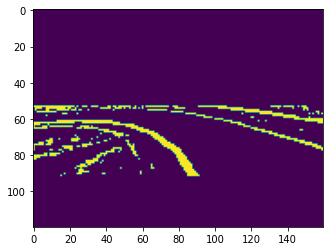

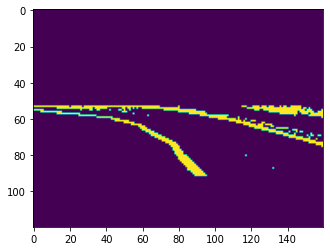

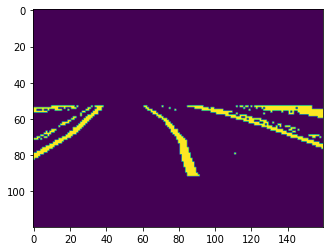

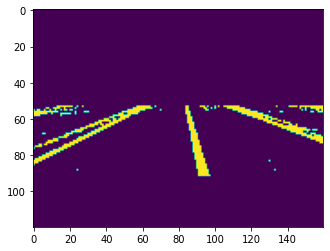

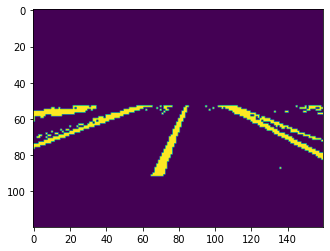

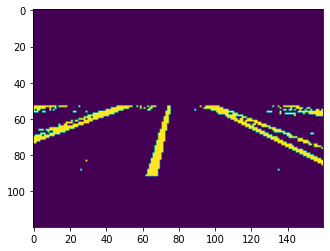

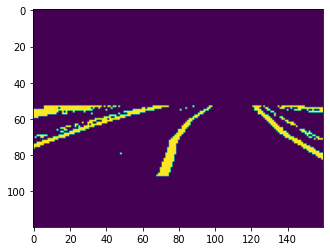

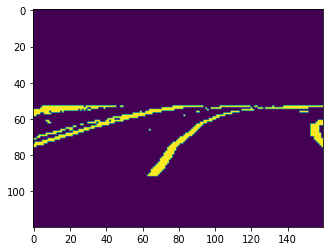

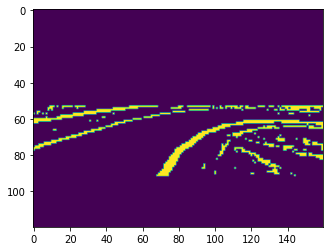

In [75]:
#Categorical Analysis Version

def CreateLabels(x_images, y_labels):
  """
  Generates a list of !!*thresholded*!! Images for which to compare inputs. 
  """
  
  comp_obj = []
  complabels = []
  y_labelsl = list(y_labels)
  for i in range(0, 15):
    if i > 7:
      value = round((i - 7)/7,8)
      index = list(map(lambda j: (j > (value-0.005) and j < (value + 0.005)) , y_labelsl)).index(True)
      comp_obj.append(x_images[index])
      complabels.append(K.argmax(x_images[index]))
    elif i == 7:
      value = 0.0
      index = list(map(lambda j: (j > (value-0.005) and j < (value + 0.005)) , y_labelsl)).index(True)
      comp_obj.append(x_images[index])
      complabels.append(K.argmax(x_images[index]))
    elif i < 7:
      #value = round(-1*((i+1)/7),8)
      #index = list(map(lambda i: (i > (value-0.13) and i < (value + 0.13)) , y_labelsl)).index(True)
      comp_obj.append(x_images[i])
      complabels.append(K.argmax(x_images[i]))
      pass
  comp_obj = np.asarray(comp_obj)
  return comp_obj, complabels

def GenerateOutputsCat(x_images, comp_obj, complabels):
  a_labels = []
  N = len(x_images)
  for i in range(0, N):
    ious = []
    for j in range(0, 15):
      ious.append(K.get_value(iou(x_images[i], comp_obj[j],complabels[j])))
    target = ious.index(max(ious))
    target += 1
    if target == 8:
      a_labels.append(0)
    elif target < 8:
      targ = 8 - target
      a_labels.append(-1*(targ/7)*ious[target -1])
    elif target > 8:
      targ = target - 8
      a_labels.append((targ/7)*ious[target-1])

  a_labels = np.asarray(a_labels)
  return a_labels

comp_obj, complabels = CreateLabels(ximagest, ylabelsa)
"""
for i in range(0,15):
  plt.imshow(comp_obj[i])
  plt.show()
"""
for i in range(0,7):
  comp_obj[i] = np.fliplr(comp_obj[14-i])
  complabels[i] = K.argmax(comp_obj[i])


for i in range(0,15):
  plt.imshow(comp_obj[i])
  plt.show()

#outlabels = GenerateOutputsCat(ximagest[100], comp_obj, complabels)

In [76]:
%%time
a_labels = []
N = len(ximagest)
#N = 1
for i in range(0, N):
  ious = []
  for j in range(0, 15):
    ious.append((iou(ximagest[i], comp_obj[j],complabels[j]).numpy())) 
  target = ious.index(max(ious))
  target += 1
  if target == 8:
    a_labels.append(0.0)
  elif target < 8:
    targ = 8 - target
    a_labels.append(-1*(targ/15)*ious[target -1])
    #a_labels.append(-1*(targ/7))
  elif target > 8:
    targ = target - 8
    a_labels.append((targ/15)*ious[target-1])
    #a_labels.append((targ/7))

CPU times: user 3min 27s, sys: 26.1 s, total: 3min 53s
Wall time: 3min 7s




## Melissa-Valuation


In [77]:
print(type(a_labels))

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from math import sqrt

rmse = sqrt(mean_squared_error(ylabelsa, np.asarray(a_labels,dtype=np.float32)))
mae = mean_absolute_error(ylabelsa, np.asarray(a_labels,dtype=np.float32))
r2 = r2_score(ylabelsa, np.asarray(a_labels,dtype=np.float32))

print("Evaluation of Melissa")
print(mae)
print(rmse)
print(r2)

<class 'list'>
Evaluation of Melissa
0.2524565
0.31994322681089504
-1.4451769343356653


In [86]:
#importing required libraries
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

img = ximagest[10]
fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
print(fd.shape)

compfeatures = []
featimgs = []
for i in range(0,15):
  fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
  compfeatures.append(fd)
  featimgs.append(hog_image)


(9576,)


In [89]:
%%time
a_labels2 = []
#N = len(ximagest)
N = 100
for i in range(0, N):
  fds = []
  for j in range(0, 15):
    fd, hog_image = hog(ximagest[i], orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=False)
    X = []
    X.append(fd)
    X.append(compfeatures[j])
    X = np.asarray(X)
    fds.append(scipy.spatial.distance.pdist(X,'euclidean')) 
  target = fds.index(min(fds))
  target += 1
  if target == 8:
    a_labels2.append(0.0)
  elif target < 8:
    targ = 8 - target
    a_labels2.append(-1*(targ/15)*fds[target -1])
    #a_labels.append(-1*(targ/7))
  elif target > 8:
    targ = target - 8
    a_labels2.append((targ/15)*fds[target-1])
    #a_labels.append((targ/7))

CPU times: user 1min 13s, sys: 0 ns, total: 1min 13s
Wall time: 1min 13s


In [91]:
rmse = sqrt(mean_squared_error(ylabelsa[:100], np.asarray(a_labels2,dtype=np.float32)))
mae = mean_absolute_error(ylabelsa[:100], np.asarray(a_labels2,dtype=np.float32))
r2 = r2_score(ylabelsa[:100], np.asarray(a_labels2,dtype=np.float32))

print("Evaluation of Melissa 2:")
print(mae)
print(rmse)
print(r2)

Evaluation of Melissa 2:
3.5177035
3.725322781089341
-1544.0633148781355
